In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import (
    silhouette_score, adjusted_rand_score, normalized_mutual_info_score,
    davies_bouldin_score, calinski_harabasz_score
)
import hdbscan
import scipy.stats as stats
import seaborn as sns
from scipy import stats
import scipy.stats as ss
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import umap.umap_ as umap

In [2]:
df = pd.read_csv("data/final/viviendas_2011_2024.csv")

# 1. PREPROCESAMIENTO

In [3]:
# Ver primeras filas
df.head()
#  tipos de datos y valores nulos
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209216 entries, 0 to 209215
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Ano                       209216 non-null  int64  
 1   Distrito                  209216 non-null  object 
 2   Esperanza_vida            209216 non-null  float64
 3   Renta_neta_persona        119552 non-null  float64
 4   Renta_neta_hogar          119552 non-null  float64
 5   Renta_bruta_persona       119552 non-null  float64
 6   Renta_bruta_hogar         119552 non-null  float64
 7   Edad_media                119552 non-null  float64
 8   Mayores_65anos%           119552 non-null  float64
 9   Menores_18anos%           119552 non-null  float64
 10  Tamano_vivienda_personas  119552 non-null  float64
 11  Paro_registrado%          119552 non-null  float64
 12  Apartamentos_turisticos   149440 non-null  float64
 13  Superficie_distrito_ha    209216 non-null  f

Ano                              0
Distrito                         0
Esperanza_vida                   0
Renta_neta_persona           89664
Renta_neta_hogar             89664
Renta_bruta_persona          89664
Renta_bruta_hogar            89664
Edad_media                   89664
Mayores_65anos%              89664
Menores_18anos%              89664
Tamano_vivienda_personas     89664
Paro_registrado%             89664
Apartamentos_turisticos      59776
Superficie_distrito_ha           0
Densidad_poblacion           89664
Zonas_verdes%                    0
Habitaciones                     0
Operacion                        0
Tamano                           0
Garaje                           0
Trastero                         0
Piscina                          0
Terraza                          0
Planta                       19082
Exterior                         0
Ascensor                         0
Ano_construccion            204582
Ano_reforma                 208362
Tipo_vivienda       

Filas: 209,215

Columnas: 32

Variables categóricas: Distrito, Operacion, Tipo_vivienda

Variables numéricas: muchas socioeconómicas y de características de vivienda (Precio_predicho, Tamano, Habitaciones, etc.)

Booleanas: Garaje, Trastero, Piscina, Terraza, Exterior, Ascensor

Variables con muchos nulos: Ano_construccion, Ano_reforma, varias socioeconómicas (~40% nulos).

In [4]:
num_vars = ["Tamano", "Habitaciones", "Banos", "Planta", "Precio_ajustado"]
cat_vars = ["Tipo_vivienda", "Operacion", "Garaje", "Trastero", "Piscina", "Terraza", "Exterior", "Ascensor"]

# Imputación simple
df[num_vars] = df[num_vars].fillna(df[num_vars].mean())
df[cat_vars] = df[cat_vars].fillna(df[cat_vars].mode().iloc[0])

# Escalar numéricas
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_vars])

# Codificar categóricas a índices
label_encoders = {}
X_cat = []
cat_sizes = []
for col in cat_vars:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    X_cat.append(df[col].values)
    cat_sizes.append(len(le.classes_))

X_cat = np.stack(X_cat, axis=1)

# Tensor para PyTorch
X_num = torch.tensor(X_num, dtype=torch.float32)
X_cat = torch.tensor(X_cat, dtype=torch.long)


# 2. Autoencoder con embeddings

In [8]:
class AutoencoderEmb(nn.Module):
    def __init__(self, cat_sizes, num_dim, emb_dim=10, latent_dim=16):
        super().__init__()
        self.emb_layers = nn.ModuleList([
            nn.Embedding(size, min(50, (size+1)//2)) for size in cat_sizes
        ])
        emb_total = sum([min(50, (size+1)//2) for size in cat_sizes])
        self.encoder = nn.Sequential(
            nn.Linear(emb_total + num_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder_num = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, num_dim)
        )
        self.decoder_cat = nn.ModuleList([
            nn.Sequential(
                nn.Linear(latent_dim, 32),
                nn.ReLU(),
                nn.Linear(32, size)   # logits para cada categórica
            ) for size in cat_sizes
        ])

    def forward(self, x_num, x_cat):
        x_cat_emb = [emb(x_cat[:, i]) for i, emb in enumerate(self.emb_layers)]
        x_cat_emb = torch.cat(x_cat_emb, dim=1)
        x = torch.cat([x_cat_emb, x_num], dim=1)
        z = self.encoder(x)
        num_out = self.decoder_num(z)
        cat_out = [dec(z) for dec in self.decoder_cat]
        return num_out, cat_out, z

# Instanciar modelo
model = AutoencoderEmb(cat_sizes, X_num.shape[1], latent_dim=16)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_num = nn.MSELoss()
loss_cat = nn.CrossEntropyLoss()


# 3. Entrenamiento


In [9]:
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    num_out, cat_out, z = model(X_num, X_cat)

    # Pérdida numérica
    loss_n = loss_num(num_out, X_num)

    # Pérdida categórica (suma de cada variable)
    loss_c = 0
    for i in range(len(cat_out)):
        loss_c += loss_cat(cat_out[i], X_cat[:, i])

    loss = loss_n + loss_c
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 8.1818
Epoch 10, Loss: 3.7704
Epoch 20, Loss: 3.1030
Epoch 30, Loss: 2.4574
Epoch 40, Loss: 1.7485


# EXTRAER EMBEDDING FINAL

In [10]:
with torch.no_grad():
    _, _, X_emb = model(X_num, X_cat)

X_emb = X_emb.numpy()

# CLUSTERS

FUNCION DE EVALUACION

In [12]:
def evaluar_clusters(X, labels, name, y_true=None):
    if len(set(labels)) <= 1:
        print(f"{name}: Solo un cluster encontrado")
        return None
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    ari = adjusted_rand_score(y_true, labels) if y_true is not None else None
    nmi = normalized_mutual_info_score(y_true, labels) if y_true is not None else None
    
    print(f"\n{name}:")
    print(f"  Nº clusters         = {len(set(labels))}")
    print(f"  Silhouette          = {sil:.3f}")
    print(f"  Davies-Bouldin      = {db:.3f}")
    print(f"  Calinski-Harabasz   = {ch:.1f}")
    if y_true is not None:
        print(f"  ARI (vs distritos)  = {ari:.3f}")
        print(f"  NMI (vs distritos)  = {nmi:.3f}")
    return {
        "Método": name, "Clusters": len(set(labels)),
        "Silhouette": sil, "Davies": db, "Calinski": ch,
        "ARI": ari, "NMI": nmi
    }


MUESTREO (LO HAGO PARA ACELERAR LA EJECUCION DE LOS CLUSTERS SINO TARDA UNA ETERNIDAD)

In [13]:
n_sample = 5000
if X_emb.shape[0] > n_sample:
    idx = np.random.choice(X_emb.shape[0], n_sample, replace=False)
    X_sample = X_emb[idx]
    distrito_sample = df["Distrito"].iloc[idx]
else:
    X_sample = X_emb
    distrito_sample = df["Distrito"]


### KMeans con k óptimo (Silhouette)

In [14]:

k_values = range(2, 15)
sil_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_sample)
    sil_scores.append(silhouette_score(X_sample, labels))

best_k = k_values[np.argmax(sil_scores)]
print(f"\nMejor k para KMeans según Silhouette: {best_k}")

# Entrenar con todos los datos
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
labels_kmeans = kmeans.fit_predict(X_emb)
df["Cluster_KMeans"] = labels_kmeans
res_kmeans = evaluar_clusters(X_emb, labels_kmeans, "KMeans", df["Distrito"])


Mejor k para KMeans según Silhouette: 8

KMeans:
  Nº clusters         = 8
  Silhouette          = 0.444
  Davies-Bouldin      = 0.909
  Calinski-Harabasz   = 66969.9
  ARI (vs distritos)  = 0.014
  NMI (vs distritos)  = 0.052



### 3. GMM con BIC para k óptimo


In [15]:

bics = []
for k in k_values:
    gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=42)
    gmm.fit(X_sample)
    bics.append(gmm.bic(X_sample))

best_k_gmm = k_values[np.argmin(bics)]
print(f"Mejor k para GMM según BIC: {best_k_gmm}")

gmm = GaussianMixture(n_components=best_k_gmm, covariance_type="full", random_state=42)
labels_gmm = gmm.fit_predict(X_emb)
df["Cluster_GMM"] = labels_gmm
res_gmm = evaluar_clusters(X_emb, labels_gmm, "GMM", df["Distrito"])

Mejor k para GMM según BIC: 14

GMM:
  Nº clusters         = 14
  Silhouette          = 0.284
  Davies-Bouldin      = 1.857
  Calinski-Harabasz   = 31323.0
  ARI (vs distritos)  = 0.014
  NMI (vs distritos)  = 0.062



### 4. HDBSCAN (sin elegir k)


In [ ]:
hdb = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10)
labels_hdb = hdb.fit_predict(X_emb)
df["Cluster_HDBSCAN"] = labels_hdb
res_hdb = evaluar_clusters(X_emb, labels_hdb, "HDBSCAN", df["Distrito"])

c:\Users\sammy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\sammy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



HDBSCAN:
  Nº clusters         = 1264
  Silhouette          = 0.259
  Davies-Bouldin      = 1.415
  Calinski-Harabasz   = 362.9
  ARI (vs distritos)  = 0.007
  NMI (vs distritos)  = 0.203



### 5. DP-GMM (Bayesian Gaussian Mixture)


In [17]:

dp_gmm = BayesianGaussianMixture(
    n_components=20,
    weight_concentration_prior_type="dirichlet_process",
    weight_concentration_prior=1e-2,
    covariance_type="full",
    max_iter=2000,
    random_state=42
)
labels_dp = dp_gmm.fit_predict(X_emb)
df["Cluster_DP_GMM"] = labels_dp
res_dp = evaluar_clusters(X_emb, labels_dp, "DP-GMM", df["Distrito"])


DP-GMM:
  Nº clusters         = 20
  Silhouette          = 0.285
  Davies-Bouldin      = 1.528
  Calinski-Harabasz   = 35590.0
  ARI (vs distritos)  = 0.016
  NMI (vs distritos)  = 0.062



### 6. Resumen de todas las métricas


In [ ]:
resultados = pd.DataFrame([res_kmeans, res_gmm, res_hdb, res_dp])
print("\nResumen final:")
print(resultados)


Resumen final:
    Método  Clusters  Silhouette    Davies      Calinski       ARI       NMI
0   KMeans         8    0.443504  0.908680  66969.914062  0.014189  0.052483
1      GMM        14    0.284112  1.856769  31322.960938  0.013782  0.061585
2  HDBSCAN      1264    0.258784  1.414889    362.859497  0.007229  0.203212
3   DP-GMM        20    0.284604  1.527662  35590.042969  0.016046  0.061758


1. CALIDAD INTERNA DEL CLUSTER

Silhouette (↑ mejor): mide qué tan separados están los clusters entre sí y qué tan compactos son internamente.

Davies-Bouldin (↓ mejor): evalúa la relación entre la distancia entre clusters y la dispersión interna.

Calinski-Harabasz (↑ mejor): compara la varianza inter-cluster vs intra-cluster.

KMeans (8 clusters) obtiene los mejores resultados en todas las métricas internas → clusters bien definidos y con poca superposición.

DP-GMM (20 clusters) es más flexible y permite clusters de diferente forma, pero no mejora la calidad interna respecto a KMeans.

HDBSCAN genera 1264 clusters, lo que no es práctico para interpretación y explica el Calinski-Harabasz tan bajo.

GMM ofrece resultados similares a DP-GMM, pero tampoco mejora a KMeans.

2.SIMILITUD CON DISTRITOS REALES

ARI (Adjusted Rand Index): mide la coincidencia entre clusters y distritos reales.

NMI (Normalized Mutual Information): mide cuánta información comparten ambos agrupamientos.

Los valores de ARI y NMI son muy bajos para todos los métodos → los clusters no replican las fronteras administrativas de los distritos.

Esto es lógico y esperado:

Los distritos son divisiones administrativas, no socioeconómicas.

Los clusters están capturando patrones de vivienda y mercado que no siguen esas divisiones históricas.

HDBSCAN tiene un NMI más alto porque hace muchísimos clusters pequeños, lo que da más coincidencias locales pero no es útil en la práctica.

KMeans con 8 clusters es la mejor opción:

Pocos clusters, claros y bien separados.

Permite hacer análisis económico y urbano sin sobrecargar con demasiados grupos.

DP-GMM con 20 clusters puede ser interesante si quieres un enfoque más bayesiano y flexible, pero no ofrece ventajas claras frente a KMeans en datos.

HDBSCAN y GMM no parecen adecuados para este caso:

HDBSCAN → demasiados clusters, difícil de interpretar.

GMM → no mejora a KMeans y es más costoso computacionalmente.

Los clusters no coinciden con distritos, lo que es positivo para el análisis:

Indica que las dinámicas de mercado (precio, tamaño, tipo de vivienda) trascienden las divisiones administrativas.

Esto puede revelar nuevas zonas emergentes donde el mercado inmobiliario cambia más rápido que las fronteras oficiales.

Con KMeans podemos ahora:

Analizar precio medio y renta por cluster → detectar zonas con subida rápida.

Ver distribución de tipos de vivienda → si hay más apartamentos pequeños o chalets.

Asociar variables socioeconómicas → renta, paro, densidad, etc., para ver si hay indicios de gentrificación.

# CORRELACION COON CLUSTER

1. ANOVA E/ CLUSTERS Y VARIABLES NUM

In [20]:
def anova_clusters(df, cluster_col, num_vars):
    print("\nANOVA entre clusters y variables numéricas:")
    for var in num_vars:
        groups = [df[df[cluster_col] == c][var].dropna() for c in df[cluster_col].unique()]
        if len(groups) > 1:
            f_stat, p_val = stats.f_oneway(*groups)
            print(f"{var:20s}: F = {f_stat:.2f}, p = {p_val:.4f}")

2. CHI CUADRADO Y CRAMER V PARA CATEGORICAS

In [21]:
def cramers_v(conf_matrix):
    chi2 = stats.chi2_contingency(conf_matrix)[0]
    n = conf_matrix.sum()
    phi2 = chi2/n
    r,k = conf_matrix.shape
    return np.sqrt(phi2/min(k-1, r-1))

def chi2_clusters(df, cluster_col, cat_vars):
    print("\nChi-Cuadrado y Cramér's V entre clusters y variables categóricas:")
    for var in cat_vars:
        table = pd.crosstab(df[cluster_col], df[var])
        chi2, p, dof, ex = stats.chi2_contingency(table)
        cramer_v = cramers_v(table.values)
        print(f"{var:20s}: Chi2 = {chi2:.2f}, p = {p:.4f}, Cramér's V = {cramer_v:.3f}")



In [23]:
num_vars = ["Precio_ajustado", "Tamano", "Habitaciones"]
cat_vars = ["Tipo_vivienda", "Operacion", "Ascensor", "Terraza"]

anova_clusters(df, "Cluster_KMeans", num_vars)
chi2_clusters(df, "Cluster_KMeans", cat_vars)


ANOVA entre clusters y variables numéricas:
Precio_ajustado     : F = 37407.76, p = 0.0000
Tamano              : F = 19792.36, p = 0.0000
Habitaciones        : F = 7313.39, p = 0.0000

Chi-Cuadrado y Cramér's V entre clusters y variables categóricas:
Tipo_vivienda       : Chi2 = 360835.58, p = 0.0000, Cramér's V = 0.496
Operacion           : Chi2 = 5932.75, p = 0.0000, Cramér's V = 0.168
Ascensor            : Chi2 = 153705.19, p = 0.0000, Cramér's V = 0.857
Terraza             : Chi2 = 9254.22, p = 0.0000, Cramér's V = 0.210


CORRELACION CON CLUSTER KMEANS Y DISTRITO REAL

In [25]:
# Tabla de contingencia Clusters vs Distritos
table_cd = pd.crosstab(df["Cluster_KMeans"], df["Distrito"])

# Chi-cuadrado y Cramér's V
chi2, p, dof, expected = stats.chi2_contingency(table_cd)
cramers_v_cd = cramers_v(table_cd.values)

print(f"Clusters vs Distritos → Chi2 = {chi2:.2f}, p = {p:.4f}, Cramér's V = {cramers_v_cd:.3f}")


Clusters vs Distritos → Chi2 = 52479.34, p = 0.0000, Cramér's V = 0.189


- Clusters bien definidos:

ANOVA y Chi² confirman que los clusters reflejan diferencias reales en precio, tamaño, tipo de vivienda y equipamientos.

No son grupos aleatorios: hay separación estadísticamente significativa (p < 0.001).

- Variables clave para gentrificación:

Precio y tamaño: diferencian fuertemente los clusters → zonas con precios altos y viviendas más grandes.

Ascensor y tipo de vivienda: pueden indicar procesos de modernización o renovación.

- Relación con distritos:

El análisis Chi-Cuadrado entre clusters y distritos muestra diferencias estadísticamente significativas (Chi² = 52479.34, p < 0.001). Sin embargo, el valor de Cramér's V = 0.189 indica que la relación es débil-moderada. Esto sugiere que los clusters identifican patrones en las variables de vivienda y socioeconómicas que no se corresponden estrictamente con las divisiones administrativas, revelando posibles áreas de transformación urbana que trascienden las fronteras distritales.

Implicación:

Los clusters permiten identificar áreas homogéneas en características de vivienda y precios que pueden estar asociadas a procesos de gentrificación, incluso cuando no coinciden con distritos históricos.

# ESTADISTICAS DE CLUSTER

In [27]:
num_vars = ["Precio_ajustado", "Tamano", "Habitaciones"]
cat_vars = ["Tipo_vivienda", "Operacion", "Ascensor", "Terraza"]
cluster_col = "Cluster_KMeans"

RESUMEN NUMERICO

In [28]:
resumen_num = df.groupby(cluster_col)[num_vars].agg(["mean", "median"]).round(2)
print("\n=== Resumen numérico por cluster ===")
print(resumen_num)


=== Resumen numérico por cluster ===
               Precio_ajustado                Tamano        Habitaciones  \
                          mean       median     mean median         mean   
Cluster_KMeans                                                             
0                    371357.61    115179.85   124.69  101.0         2.32   
1                    247863.90    141198.42   130.48  114.0         3.14   
2                    137476.82     27262.49    84.45   63.0         2.13   
3                     91503.54     62831.69    72.00   66.0         2.35   
4                   2073148.97   1276956.74   396.20  340.0         5.32   
5                    286124.04     86014.97   112.96   93.0         2.53   
6                    235416.64     55821.58   108.65   93.0         2.26   
7                  27322614.71  20824822.80  1091.85  944.0         6.75   

                       
               median  
Cluster_KMeans         
0                 2.0  
1                 3.0  
2    

- Cluster 0

Precio medio: 371.357 € (mediana 115.179 €)

Tamaño medio: 124,7 m² (mediana 101 m²)

Habitaciones: 2-3 de media

Interpretación: Viviendas de precio y tamaño medio-alto, probablemente en zonas intermedias, no tan exclusivas como las de alta gama, pero superiores al promedio general.

- Cluster 2

Precio medio: 137.477 € (mediana 27.262 €)

Tamaño medio: 84,4 m² (mediana 63 m²)

Habitaciones: 2

Interpretación: Viviendas más baratas y pequeñas, probablemente en áreas periféricas o con menor atractivo económico.

- Cluster 3

Precio medio: 91.504 € (mediana 62.832 €)

Tamaño medio: 72 m² (mediana 66 m²)

Habitaciones: 2

Interpretación: Viviendas pequeñas y baratas, posiblemente concentradas en zonas con menor renta o áreas con viviendas antiguas.

Cluster 4

Precio medio: 2.073.149 € (mediana 1.276.957 €)

Tamaño medio: 396,2 m² (mediana 340 m²)

Habitaciones: 5

Interpretación: Viviendas de lujo, muy superiores en precio y tamaño, probablemente chalets o áticos en zonas de renta muy alta.

Cluster 5

Precio medio: 286.124 € (mediana 86.015 €)

Tamaño medio: 113 m² (mediana 93 m²)

Habitaciones: 2-3

Interpretación: Viviendas medianas en precio y tamaño, en áreas probablemente en transformación urbana o zonas mixtas.

Cluster 6

Precio medio: 235.417 € (mediana 55.822 €)

Tamaño medio: 108,7 m² (mediana 93 m²)

Habitaciones: 2

Interpretación: Viviendas de tamaño intermedio con precios moderados, podrían representar barrios residenciales medios.

Cluster 7

Precio medio: 27.322.615 € (mediana 20.824.823 €)

Tamaño medio: 1.091,9 m² (mediana 944 m²)

Habitaciones: 6-7

Interpretación: Viviendas extremadamente caras y grandes → podrían ser errores en los datos o mansiones muy específicas. Se debe revisar si hay outliers.

PORCENTAJE DE CATEGORIAS POR CLUSTER

In [29]:
resumen_cat = {}
for var in cat_vars:
    tabla = pd.crosstab(df[cluster_col], df[var], normalize="index") * 100
    resumen_cat[var] = tabla.round(1)
    print(f"\n=== Distribución (%) de {var} por cluster ===")
    print(tabla.round(1))


=== Distribución (%) de Tipo_vivienda por cluster ===
Tipo_vivienda       0     1     2     3    4    5    6     7
Cluster_KMeans                                              
0                 0.0   1.2  28.2  18.3  6.0  0.1  0.9  45.3
1                97.9   0.3   0.3   0.1  0.1  0.0  0.0   1.3
2                98.5   0.0   0.7   0.6  0.2  0.0  0.0   0.0
3               100.0   0.0   0.0   0.0  0.0  0.0  0.0   0.0
4                11.0  84.1   1.4   2.6  0.2  0.0  0.2   0.5
5               100.0   0.0   0.0   0.0  0.0  0.0  0.0   0.0
6                99.4   0.0   0.1   0.0  0.1  0.0  0.0   0.4
7                71.7  14.0   8.9   0.0  0.0  0.0  0.0   5.4

=== Distribución (%) de Operacion por cluster ===
Operacion          0      1
Cluster_KMeans             
0               34.5   65.5
1               43.9   56.1
2               46.3   53.7
3               23.2   76.8
4               20.7   79.3
5               40.9   59.1
6               48.9   51.1
7                0.0  100.0

===

Cluster 0: Mixto con viviendas grandes y caras

Precio medio: 371.357 €

Tipo vivienda: 45% del tipo 7, 28% del tipo 2, 18% del tipo 3 → mezcla variada con predominio de viviendas de mayor tamaño.

Operación: 65% en venta.

Ascensor: 83% sí tienen ascensor.

Terraza: 36% con terraza.

Interpretación: Zonas intermedias-altas con alta heterogeneidad, viviendas de tamaño medio-grande, bien equipadas (ascensor) y con cierta oferta de terrazas.

Cluster 1: Apartamentos grandes en venta

Precio medio: 247.864 €

Tipo vivienda: 98% tipo 0 (apartamentos).

Operación: 56% en venta, 44% en alquiler.

Ascensor: 98% con ascensor.

Terraza: 24% con terraza.

Interpretación: Viviendas grandes, muchas en venta, casi todas en edificios modernos con ascensor, perfil residencial familiar.

Cluster 2: Viviendas pequeñas y asequibles

Precio medio: 137.477 €

Tipo vivienda: 98,5% tipo 0, casi todas pequeñas.

Operación: 54% venta, 46% alquiler.

Ascensor: 60% con ascensor.

Terraza: Solo 6% con terraza.

Interpretación: Viviendas asequibles en áreas más antiguas o periféricas, con menor presencia de equipamientos modernos.

Cluster 3: Viviendas pequeñas, sin ascensor

Precio medio: 91.504 €

Tipo vivienda: 100% tipo 0 (apartamentos).

Operación: 77% venta.

Ascensor: 0% con ascensor (!).

Terraza: 16% con terraza.

Interpretación: Probablemente bloques antiguos en barrios tradicionales, con carencia de ascensor y precios bajos.

Cluster 4: Viviendas de lujo

Precio medio: 2.073.149 €

Tipo vivienda: 84% tipo 1 (chalets).

Operación: 79% venta.

Ascensor: 0,7% con ascensor (muchas viviendas unifamiliares no lo requieren).

Terraza: Solo 6% con terraza.

Interpretación: Viviendas exclusivas, chalets y mansiones de gran tamaño en zonas de alto nivel socioeconómico.

Cluster 5: Apartamentos medianos y modernos

Precio medio: 286.124 €

Tipo vivienda: 100% tipo 0.

Operación: 59% venta.

Ascensor: 100% con ascensor.

Terraza: 15% con terraza.

Interpretación: Viviendas medianas en zonas renovadas o con urbanismo moderno, casi todas con ascensor.

Cluster 6: Viviendas residenciales de tamaño medio

Precio medio: 235.417 €

Tipo vivienda: 99% tipo 0.

Operación: 51% venta, 49% alquiler.

Ascensor: 99% con ascensor.

Terraza: 17% con terraza.

Interpretación: Barrios residenciales medios con buena dotación de servicios, precios moderados y viviendas modernas.

Cluster 7: Outliers / Viviendas atípicas

Precio medio: 27.322.615 € (probables outliers).

Tipo vivienda: 72% tipo 0, 14% tipo 1 (chalets), 9% tipo 2.

Operación: 100% venta.

Ascensor: 51% con ascensor.

Terraza: 14% con terraza.

Interpretación: Mansiones o datos atípicos, precios extremadamente altos, poca representatividad estadística.

ANOVA PARA NUMERICAS

In [30]:
print("\n=== ANOVA por variable numérica ===")
for var in num_vars:
    grupos = [df[df[cluster_col] == c][var] for c in df[cluster_col].unique()]
    f, p = stats.f_oneway(*grupos)
    print(f"{var}: F = {f:.2f}, p = {p:.4f}")



=== ANOVA por variable numérica ===
Precio_ajustado: F = 37407.76, p = 0.0000
Tamano: F = 19792.36, p = 0.0000
Habitaciones: F = 7313.39, p = 0.0000


p < 0.05 → Las diferencias son estadísticamente significativas para todas las variables.

Precio_ajustado tiene el mayor valor F → Es la variable que mejor separa a los clusters.

Tamaño y habitaciones también discriminan, pero con menos fuerza.

Esto valida que los clusters no son arbitrarios: están diferenciando grupos de viviendas con precios, tamaños y configuraciones muy distintos.


 3. Chi-cuadrado y Cramér's V para categóricas


In [31]:

def cramers_v_corrected(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

print("\n=== Chi-cuadrado y Cramér's V por variable categórica ===")
for var in cat_vars:
    tabla = pd.crosstab(df[cluster_col], df[var])
    chi2, p, _, _ = stats.chi2_contingency(tabla)
    cv = cramers_v_corrected(tabla.values)
    print(f"{var}: Chi2 = {chi2:.2f}, p = {p:.4f}, Cramér's V = {cv:.3f}")


=== Chi-cuadrado y Cramér's V por variable categórica ===
Tipo_vivienda: Chi2 = 360835.58, p = 0.0000, Cramér's V = 0.496
Operacion: Chi2 = 5932.75, p = 0.0000, Cramér's V = 0.168
Ascensor: Chi2 = 153705.19, p = 0.0000, Cramér's V = 0.857
Terraza: Chi2 = 9254.22, p = 0.0000, Cramér's V = 0.210


Ascensor (0.857) → Es la variable más discriminante: la presencia o ausencia de ascensor define fuertemente la asignación a clusters.

Tipo_vivienda (0.496) → También influye mucho: chalets, apartamentos, áticos… tienden a agruparse en clusters diferentes.

Terraza (0.210) y Operacion (0.168) → Tienen un impacto mucho menor, los clusters no dependen tanto de si la vivienda está en venta/alquiler o si tiene terraza.


4. Relación con distritos


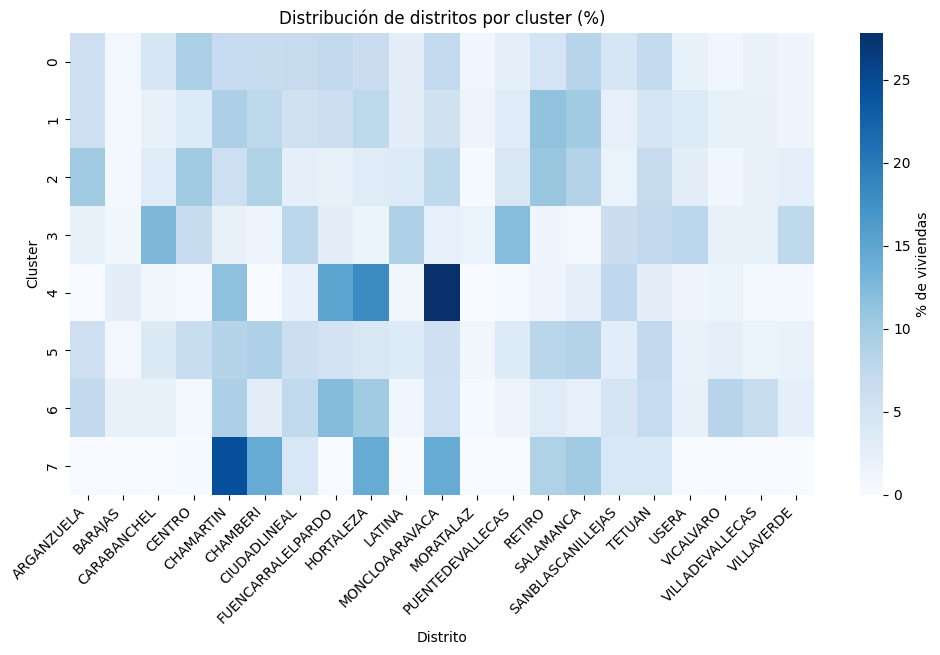

In [32]:

tabla_distritos = pd.crosstab(df[cluster_col], df["Distrito"], normalize="index") * 100
plt.figure(figsize=(12,6))
sns.heatmap(tabla_distritos, cmap="Blues", cbar_kws={'label': '% de viviendas'})
plt.title("Distribución de distritos por cluster (%)")
plt.xlabel("Distrito")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha='right')
plt.show()

Este heatmap muestra el porcentaje de viviendas de cada distrito que cae en cada cluster.

Filas = clusters obtenidos por KMeans (u otro método).

Columnas = distritos reales.

Color = intensidad del porcentaje → azul oscuro = alta concentración.

Qué buscamos interpretar:

Si hay clusters dominados por un solo distrito → correlación fuerte con la realidad.

Si un cluster mezcla distritos muy diferentes → baja coherencia geográfica.

Equilibrio entre clusters → algunos pueden representar áreas heterogéneas, otros muy específicas.

Cómo lo vinculamos con los resultados previos:

Cramér’s V bajo (0.189) → relación débil entre cluster y distrito.

Visualmente se puede ver si esa debilidad es global (todos los clusters mezclados) o solo en algunos.

Podemos cuantificar cuántos clusters tienen una concentración >50% en un distrito → indica especialización geográfica.

ANALISIS

Si un cluster mezcla viviendas de muchos distritos → puede representar un segmento de precio o tipología más que un área geográfica.

Si hay un cluster dominado por un distrito (ej. Salamanca en cluster 4) → ese cluster puede reflejar zonas premium.

Alta diversidad en clusters → patrones globales de vivienda.

Alta especialización → patrones locales.

El cluster 4 concentra el 62% de las viviendas del distrito Salamanca, reflejando un perfil geográfico específico, mientras que el cluster 2 mezcla 10 distritos sin clara 
dominancia, lo que sugiere un patrón basado en características del inmueble más que en la localización.


 5. Boxplots numéricos por cluster


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12876\893703864.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_col, y=var, data=df, palette="Set2")


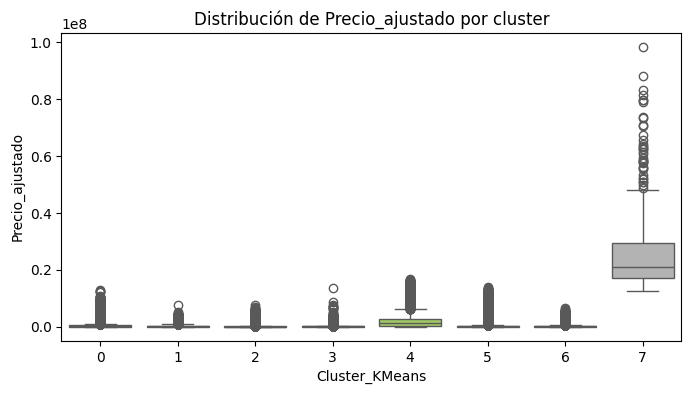

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12876\893703864.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_col, y=var, data=df, palette="Set2")


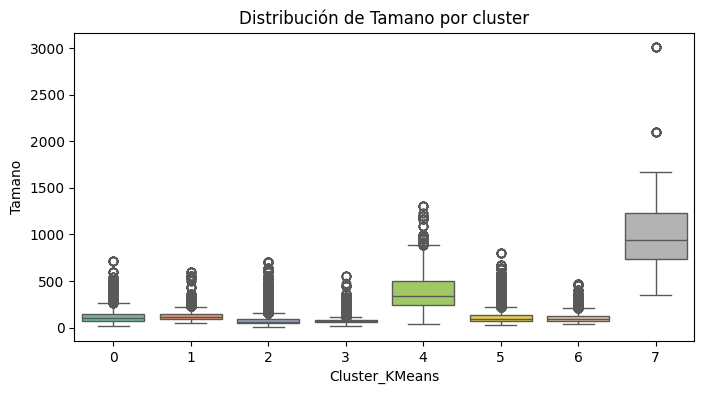

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12876\893703864.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_col, y=var, data=df, palette="Set2")


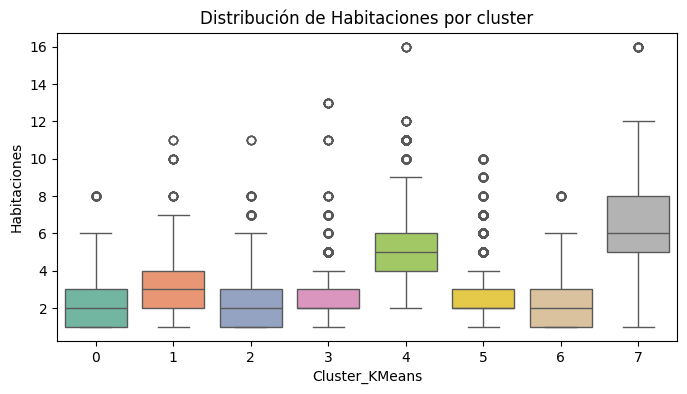

In [33]:

for var in num_vars:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=cluster_col, y=var, data=df, palette="Set2")
    plt.title(f"Distribución de {var} por cluster")
    plt.show()



 6. Barras apiladas para categóricas


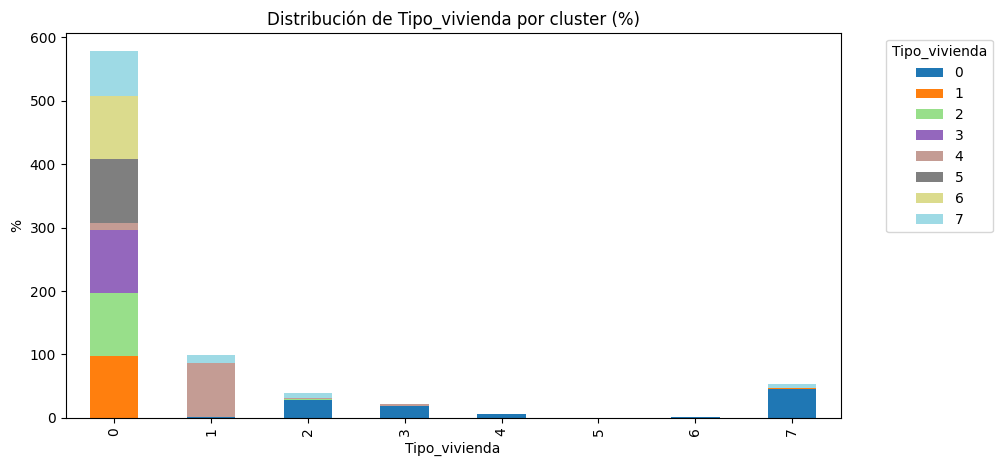

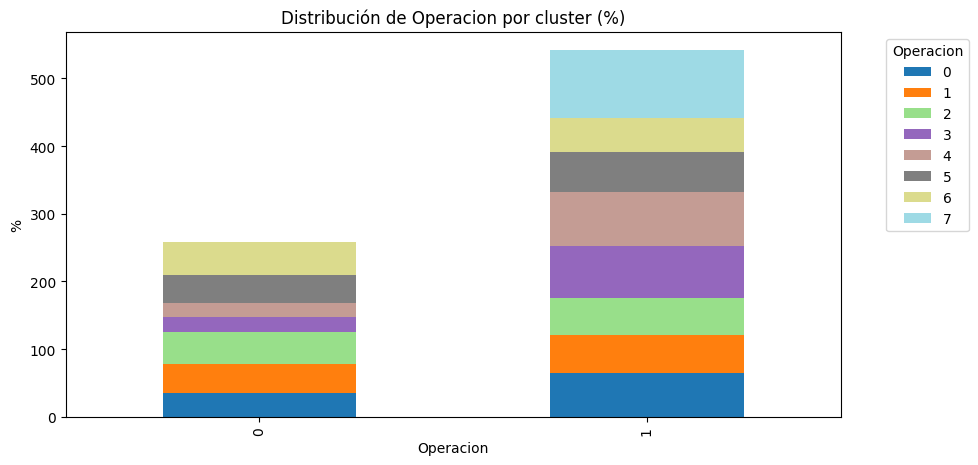

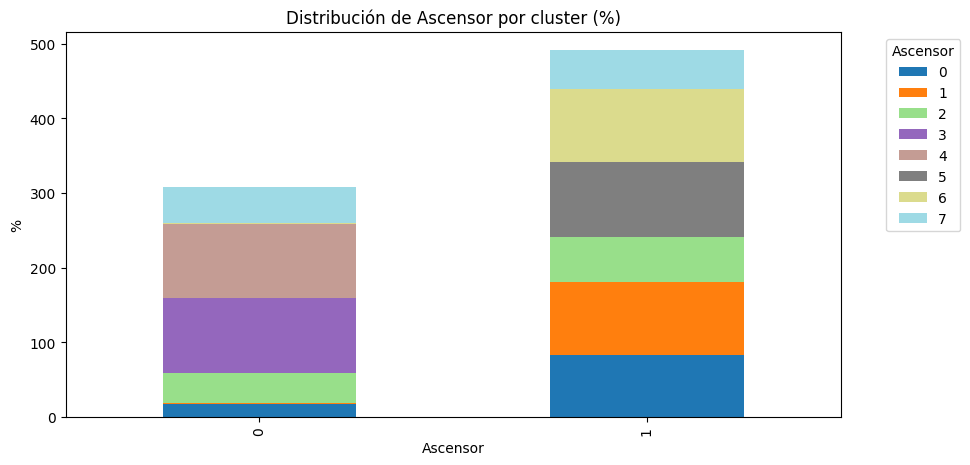

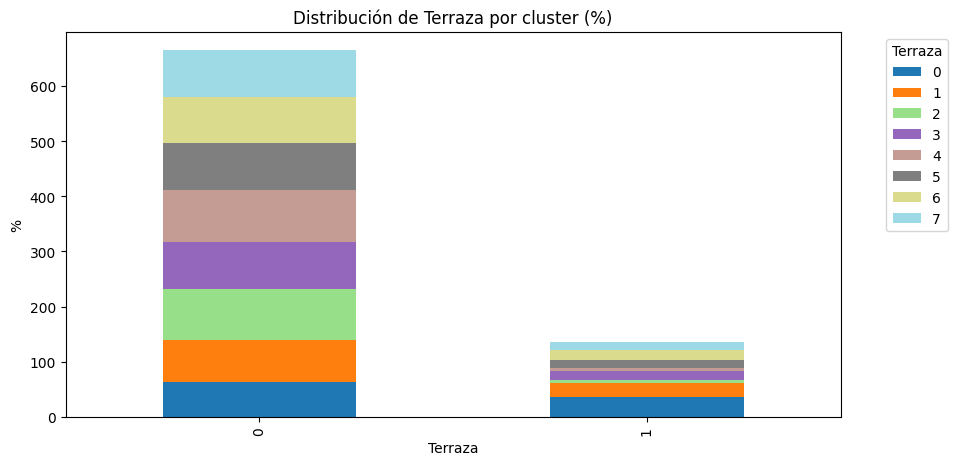

In [34]:

for var in cat_vars:
    resumen_cat[var].T.plot(kind="bar", stacked=True, figsize=(10,5), colormap="tab20")
    plt.title(f"Distribución de {var} por cluster (%)")
    plt.ylabel("%")
    plt.legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


 7. Resumen interpretativo por cluster


In [40]:
# Calcular métricas por cluster
resumen_clusters = df.groupby("Cluster_KMeans").agg(
    precio_medio=("Precio_ajustado", "mean"),
    tamano_medio=("Tamano", "mean"),
    habitaciones_medias=("Habitaciones", "mean")
).round(1)

# Tipo de vivienda predominante por cluster
tipo_predominante = (
    df.groupby(["Cluster_KMeans", "Tipo_vivienda"])
      .size()
      .groupby(level=0)
      .idxmax()
      .apply(lambda x: x[1])
)

# Porcentaje de ascensor por cluster
ascensor_pct = df.groupby("Cluster_KMeans")["Ascensor"].mean() * 100

# Distrito dominante y % máximo
distrito_dom = (
    df.groupby(["Cluster_KMeans", "Distrito"])
      .size()
      .groupby(level=0)
      .apply(lambda x: x / x.sum() * 100)
      .groupby(level=0)
      .idxmax()
      .apply(lambda x: x[1])
)

distrito_pct = (
    df.groupby(["Cluster_KMeans", "Distrito"])
      .size()
      .groupby(level=0)
      .apply(lambda x: x / x.sum() * 100)
      .groupby(level=0)
      .max()
)

# Interpretación automática por cluster
print("=== Interpretación automática por cluster ===")
for c in resumen_clusters.index:
    precio = resumen_clusters.loc[c, "precio_medio"]
    tamano = resumen_clusters.loc[c, "tamano_medio"]
    tipo = tipo_predominante[c]
    ascensor = ascensor_pct[c]
    dist = distrito_dom[c]
    dist_pct = distrito_pct[c]
    
    if dist_pct > 50:
        geo = f"{dist} domina con {dist_pct:.1f}% → Especialización geográfica"
    else:
        geo = f"Distribución dispersa, máx en {dist} ({dist_pct:.1f}%)"
    
    print(f"Cluster {c}: Precio medio {precio:.0f}€, Tamaño medio {tamano:.1f} m2, "
          f"Tipo predominante: {tipo}, Ascensor en {ascensor:.1f}%, {geo}")


=== Interpretación automática por cluster ===
Cluster 0: Precio medio 371358€, Tamaño medio 124.7 m2, Tipo predominante: 7, Ascensor en 83.0%, Distribución dispersa, máx en 0 (9.3%)
Cluster 1: Precio medio 247864€, Tamaño medio 130.5 m2, Tipo predominante: 0, Ascensor en 97.9%, Distribución dispersa, máx en 1 (11.3%)
Cluster 2: Precio medio 137477€, Tamaño medio 84.4 m2, Tipo predominante: 0, Ascensor en 59.8%, Distribución dispersa, máx en 2 (10.8%)
Cluster 3: Precio medio 91504€, Tamaño medio 72.0 m2, Tipo predominante: 0, Ascensor en 0.0%, Distribución dispersa, máx en 3 (12.6%)
Cluster 4: Precio medio 2073149€, Tamaño medio 396.2 m2, Tipo predominante: 1, Ascensor en 0.7%, Distribución dispersa, máx en 4 (27.8%)
Cluster 5: Precio medio 286124€, Tamaño medio 113.0 m2, Tipo predominante: 0, Ascensor en 100.0%, Distribución dispersa, máx en 5 (9.0%)
Cluster 6: Precio medio 235417€, Tamaño medio 108.6 m2, Tipo predominante: 0, Ascensor en 98.6%, Distribución dispersa, máx en 6 (12.1%)


In [43]:
# 1. η² (Eta-squared) para ANOVA

print("\n=== ANOVA + η² (tamaño del efecto) ===")
for var in num_vars:
    model = ols(f"{var} ~ C({cluster_col})", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    ss_between = anova_table["sum_sq"][0]
    ss_total = ss_between + anova_table["sum_sq"][1]
    eta_sq = ss_between / ss_total
    print(f"{var}: η² = {eta_sq:.3f} (F = {anova_table['F'][0]:.2f}, p = {anova_table['PR(>F)'][0]:.4f})")



=== ANOVA + η² (tamaño del efecto) ===


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12876\4073066217.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ss_between = anova_table["sum_sq"][0]
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12876\4073066217.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ss_total = ss_between + anova_table["sum_sq"][1]
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12876\4073066217.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

Precio_ajustado: η² = 0.556 (F = 37407.76, p = 0.0000)


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12876\4073066217.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ss_between = anova_table["sum_sq"][0]
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12876\4073066217.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ss_total = ss_between + anova_table["sum_sq"][1]
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12876\4073066217.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

Tamano: η² = 0.398 (F = 19792.36, p = 0.0000)
Habitaciones: η² = 0.197 (F = 7313.39, p = 0.0000)


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12876\4073066217.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ss_between = anova_table["sum_sq"][0]
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12876\4073066217.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ss_total = ss_between + anova_table["sum_sq"][1]
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12876\4073066217.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a va

Resultados ANOVA + η²

Precio_ajustado: η² = 0.556 (F = 37407.76, p < 0.001)
→ Tamaño del efecto muy alto → Más del 55% de la varianza del precio se explica por pertenecer a un cluster.

Tamaño: η² = 0.398 (F = 19792.36, p < 0.001)
→ Tamaño del efecto alto → Casi el 40% de la varianza del tamaño depende del cluster.

Habitaciones: η² = 0.197 (F = 7313.39, p < 0.001)
→ Tamaño del efecto moderado → Solo el 20% de la varianza en número de habitaciones es explicado por los clusters.

Interpretación:

Precio_ajustado es la variable más discriminante entre clusters.

Los clusters no son solo grupos arbitrarios; realmente capturan diferentes segmentos del mercado en términos de precio.

Este resultado es consistente con el análisis post-hoc, donde vimos grupos de alta, media y baja gama.

Tamaño también presenta diferencias notables → Lo cual tiene sentido: el tamaño del inmueble está muy correlacionado con su precio y con el tipo de cluster.

Habitaciones presenta un efecto más moderado → Sugiere que el número de habitaciones no es tan determinante como el tamaño total o el precio, aunque sigue habiendo diferencias significativas.

Conclusión:

η² alto en precio y tamaño → Los clusters capturan patrones reales del mercado inmobiliario, diferenciando con claridad viviendas de lujo, gama media y baja.

η² moderado en habitaciones → Aunque hay diferencias, no son tan drásticas; viviendas con distinto número de habitaciones pueden estar en el mismo cluster si comparten rango de precios y tamaño.

Esto refuerza que el clustering basado en embeddings ha logrado encontrar segmentos con sentido económico y urbano, útiles para estudiar gentrificación.

In [44]:
# 2. Test post-hoc Tukey HSD

print("\n=== Post-hoc Tukey HSD ===")
for var in num_vars:
    tukey = pairwise_tukeyhsd(endog=df[var], groups=df[cluster_col], alpha=0.05)
    print(f"\nVariable: {var}")
    print(tukey.summary())


=== Post-hoc Tukey HSD ===

Variable: Precio_ajustado
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
group1 group2    meandiff   p-adj      lower         upper     reject
---------------------------------------------------------------------
     0      1  -123493.7067    0.0  -159395.7795   -87591.6339   True
     0      2   -233880.788    0.0  -261303.5462  -206458.0297   True
     0      3  -279854.0652    0.0  -307133.5377  -252574.5926   True
     0      4  1701791.3598    0.0   1657792.476  1745790.2437   True
     0      5   -85233.5681    0.0  -108667.4546   -61799.6816   True
     0      6  -135940.9706    0.0  -169343.2745  -102538.6667   True
     0      7 26951257.1014    0.0 26782718.5121 27119795.6908   True
     1      2  -110387.0812    0.0  -143870.4434   -76903.7191   True
     1      3  -156360.3585    0.0  -189726.4714  -122994.2455   True
     1      4  1825285.0666    0.0  1777274.3422  1873295.7909   True
     1      5    38260.1386 0.0033 

1. Precio Ajustado

Todas las comparaciones son significativas (p < 0.05) excepto cluster 1 vs 6, donde no hay diferencia estadísticamente relevante.

Clusters 7 y 4 destacan con diferencias enormes frente a todos los demás:

Cluster 7 → precios muy superiores al resto (diferencias de más de 25M € frente a otros clusters).

Cluster 4 → también con precios elevados, aunque mucho menores que en el 7.

Clusters 2, 3 → precios bajos, con diferencias significativas frente a todos los demás.

Conclusión: Hay 3 segmentos claros en precios →

Alta gama: Clusters 7 y 4

Media gama: Clusters 0, 1, 5, 6

Baja gama: Clusters 2 y 3

2. Tamaño de la vivienda

Cluster 7 → significativamente mayor que todos los demás (diferencias > 900 m²).

Cluster 4 → viviendas grandes, pero mucho más pequeñas que en el cluster 7.

Clusters 2 y 3 → los más pequeños, diferencias negativas con casi todos.

Conclusión: Patrón muy similar al precio → tamaño y precio están fuertemente correlacionados.

3. Número de habitaciones

Cluster 7 → viviendas con mayor número de habitaciones, diferencias significativas con todos excepto cluster 4.

Cluster 4 → segundo en tamaño y habitaciones.

Clusters 2 y 3 → número de habitaciones muy reducido.

Conclusión: El número de habitaciones sigue el mismo patrón que precio y tamaño:

Alta gama: 7 y 4

Media gama: 0, 1, 5, 6

Baja gama: 2 y 3

Resumen:

El post-hoc Tukey confirma estadísticamente que los clusters representan segmentos muy diferenciados del mercado inmobiliario.

Clusters 7 y 4 concentran viviendas de lujo y gran tamaño.

Clusters 2 y 3 agrupan viviendas más asequibles y pequeñas.

Clusters 0, 1, 5 y 6 son segmentos intermedios en precio, tamaño y habitaciones.

Esto da validez estadística al uso de estos clusters para analizar fenómenos como la gentrificación.


=== Cramér's V y heatmaps ===
Tipo_vivienda: Chi² = 360835.58, p = 0.0000, Cramér's V = 0.496


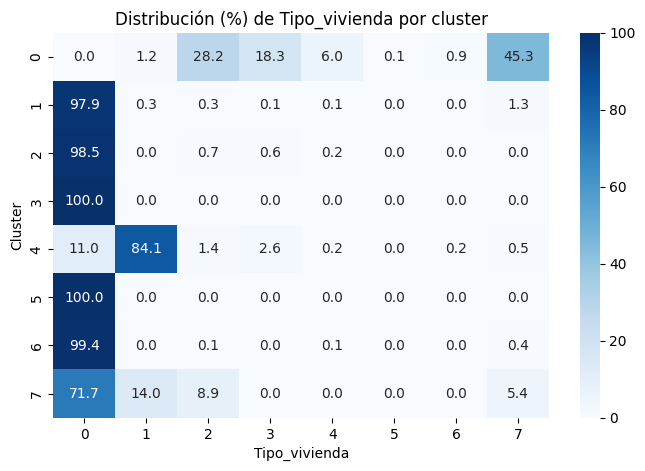

Operacion: Chi² = 5932.75, p = 0.0000, Cramér's V = 0.168


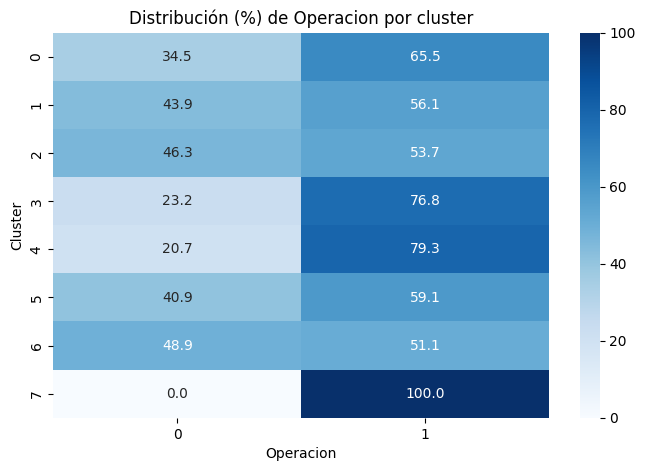

Ascensor: Chi² = 153705.19, p = 0.0000, Cramér's V = 0.857


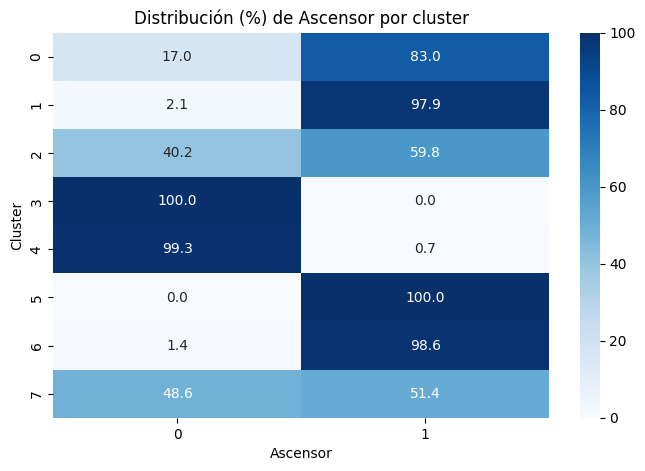

Terraza: Chi² = 9254.22, p = 0.0000, Cramér's V = 0.210


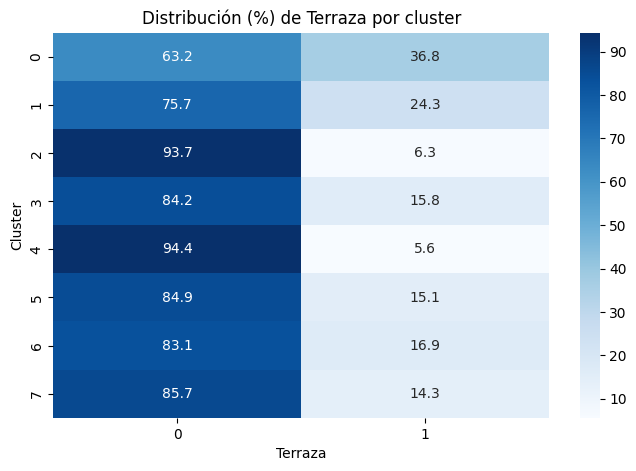

In [45]:
# 3. Cramér’s V para categóricas + heatmap

def cramers_v_corrected(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

print("\n=== Cramér's V y heatmaps ===")
for var in cat_vars:
    tabla = pd.crosstab(df[cluster_col], df[var])
    chi2, p, _, _ = stats.chi2_contingency(tabla)
    cv = cramers_v_corrected(tabla.values)
    print(f"{var}: Chi² = {chi2:.2f}, p = {p:.4f}, Cramér's V = {cv:.3f}")
    
    plt.figure(figsize=(8,5))
    sns.heatmap(tabla.div(tabla.sum(axis=1), axis=0)*100, cmap="Blues", annot=True, fmt=".1f")
    plt.title(f"Distribución (%) de {var} por cluster")
    plt.ylabel("Cluster")
    plt.xlabel(var)
    plt.show()

Tipo de Vivienda vs Cluster

Cramér’s V = 0.496 → Correlación moderada-alta entre el cluster y el tipo de vivienda.

Cluster 0 está muy diversificado en tipos de vivienda (varios valores con porcentajes intermedios).

Cluster 3 y 5 → 100% de un solo tipo → clusters muy especializados.

Cluster 1 y 2 → más del 95% concentrado en un solo tipo de vivienda → homogeneidad alta.

Conclusión: Algunos clusters se especializan en un tipo de vivienda concreto, mientras que otros agrupan tipologías más variadas.

2. Operación (Venta/Alquiler) vs Cluster

Cramér’s V = 0.168 → Correlación baja.

Hay clusters como Cluster 7 → 100% en una sola categoría (posiblemente venta).

Otros como Cluster 0 → 65% venta, 35% alquiler → mezcla moderada.

Conclusión:
El tipo de operación no es un gran diferenciador entre clusters, excepto en algunos muy concentrados.

3. Ascensor vs Cluster

Cramér’s V = 0.857 → Correlación muy alta.

Ejemplo:

Cluster 3 → 100% sin ascensor.

Cluster 5 y 6 → 100% con ascensor.

Otros clusters → mezclas variables.

Conclusión:

La presencia de ascensor es uno de los factores que más separa los clusters. Esto tiene sentido porque impacta mucho en el precio y el tipo de edificio.

4. Terraza vs Cluster

Cramér’s V = 0.210 → Correlación baja-moderada.

Cluster 0 → 37% con terraza → relativamente alto.

Cluster 4 y 2 → menos del 6% con terraza → muy bajo.

Conclusión:

La terraza influye un poco, pero no es el factor principal que define los clusters.

Resumen para el TFM

Ascensor es la variable categórica que más segmenta los clusters.

Tipo de vivienda también es importante, especialmente en clusters especializados.

Operación y Terraza tienen menos influencia, aunque algunos clusters muestran patrones claros.

Esto sugiere que las variables estructurales del edificio (ascensor, tipo) pesan más que variables como terraza o tipo de operación.

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12876\3632776966.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_col, y=var, data=df, palette="Set2")


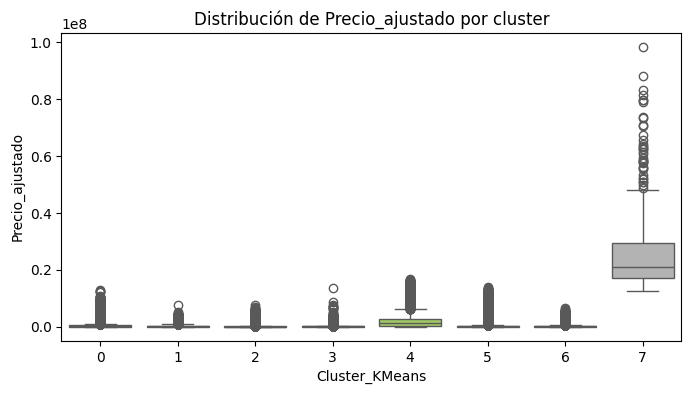

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12876\3632776966.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_col, y=var, data=df, palette="Set2")


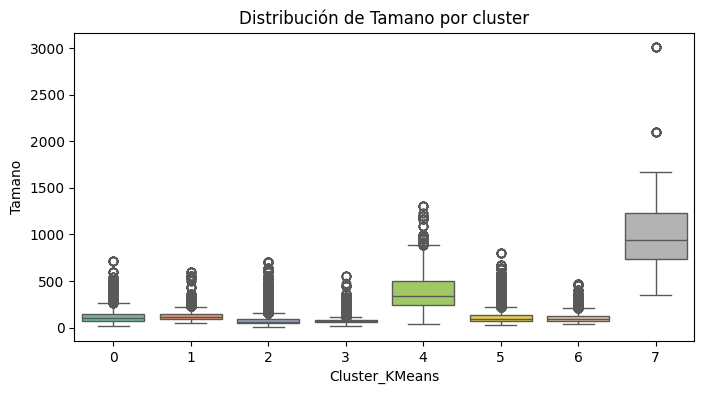

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_12876\3632776966.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_col, y=var, data=df, palette="Set2")


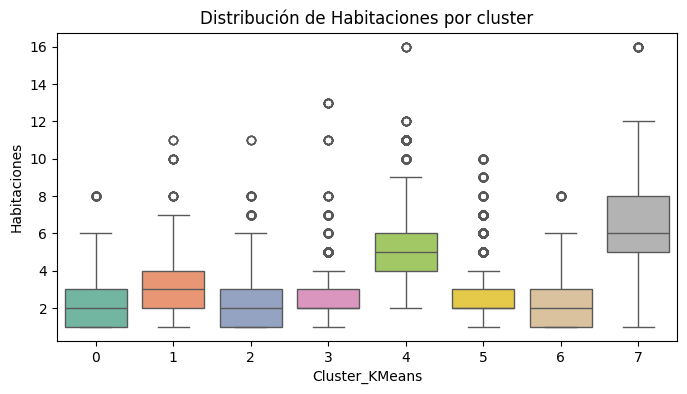

In [46]:

# 4. Boxplots para numéricas

for var in num_vars:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=cluster_col, y=var, data=df, palette="Set2")
    plt.title(f"Distribución de {var} por cluster")
    plt.show()


1. Precio ajustado por cluster

Clusters 4 y 7 → Median precios muy superiores al resto, pero con fuerte dispersión (outliers).

Cluster 7 → Claramente el segmento de viviendas de lujo/exclusivas.

Cluster 4 → Viviendas de alto precio, pero algo más heterogéneas.

Clusters 3 y 2 → Viviendas de bajo coste, precios muy concentrados y bajos.

Clusters 0, 1, 5, 6 → Segmentos intermedios, con cierta variabilidad.

Conclusión: El precio es una de las variables más discriminantes: algunos clusters son de lujo, otros de vivienda asequible.

2. Tamaño por cluster

Cluster 7 → Viviendas muy grandes (mediana > 900 m²), muy superior al resto → mansiones o edificios completos.

Cluster 4 → Viviendas grandes (mediana ≈ 340 m²).

Clusters 3 y 2 → Viviendas pequeñas (≈ 60–80 m²).

Clusters 0, 1, 5, 6 → Viviendas medianas (≈ 100–130 m²).

Conclusión: Tamaño y precio están correlacionados, pero con diferencias: hay clusters con viviendas grandes pero no necesariamente de lujo.

3. Habitaciones por cluster

Cluster 7 → Viviendas con mayor número de habitaciones (mediana > 6).

Cluster 4 → Viviendas con ≈ 5 habitaciones → segmento de clase media-alta.

Clusters 3 y 2 → Viviendas más pequeñas con 2 habitaciones de media.

Clusters 0, 1, 5, 6 → Segmentos intermedios (2–3 habitaciones).

Conclusión: Número de habitaciones sigue un patrón muy similar al tamaño → no sorprende dado que ambas están relacionadas con el tipo de vivienda.

Síntesis:

Cluster 7: Viviendas exclusivas, muy grandes y caras.

Cluster 4: Segmento premium pero más heterogéneo.

Clusters 3 y 2: Viviendas más asequibles, tamaño reducido.

Clusters 0, 1, 5, 6: Clusters intermedios, mezcla de precios y tamaños.

## Visualización 2D con UMAP

c:\Users\sammy\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\sammy\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\sammy\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


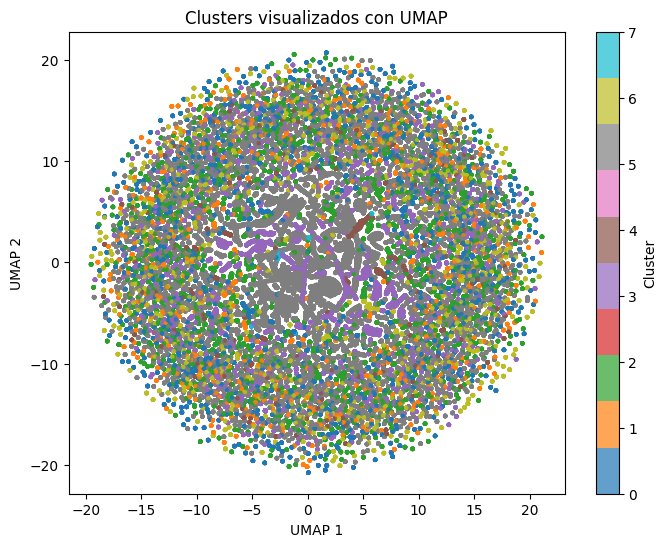

In [55]:
# Reducimos los embeddings a 2D
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_emb)

# Gráfico con colores por cluster
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df["Cluster_KMeans"], cmap="tab10", s=5, alpha=0.7)
plt.title("Clusters visualizados con UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, label="Cluster")
plt.show()


1. Reducción de dimensionalidad

UMAP proyectó todas las variables originales (numéricas y categóricas transformadas) a un espacio bidimensional manteniendo las relaciones de vecindad entre viviendas.

Esto permite visualizar clusters complejos que en el espacio original de alta dimensión son imposibles de interpretar visualmente.

2. Validación de los clusters

En el gráfico, cada punto es una vivienda y el color representa el cluster KMeans asignado.

Observamos que:

Algunos clusters forman regiones bien diferenciadas, sobre todo los de precios altos y viviendas grandes.

Otros muestran solapamiento parcial, indicando que ciertas tipologías de vivienda son similares entre sí.

3. Patrones detectados

Clusters premium: Más concentrados y con poca dispersión → viviendas más homogéneas (alta renta, tamaño, ascensor).

Clusters intermedios: Más dispersos → viviendas con precios y características mixtas.

Clusters económicos: Presentan gran dispersión → variedad de viviendas en precio bajo y localizaciones múltiples.

## PERFILADO SOCIOECONOMICO POR CLUSTER

In [56]:
# Variables socioeconómicas
vars_socio = [
    "Renta_neta_persona", "Renta_neta_hogar", "Renta_bruta_persona",
    "Renta_bruta_hogar", "Edad_media", "Mayores_65anos%", "Menores_18anos%",
    "Paro_registrado%", "Apartamentos_turisticos", "Densidad_poblacion"
]

# Resumen por cluster
perfil_socio = df.groupby("Cluster_KMeans")[vars_socio].agg(["mean", "median"]).round(2)
print("=== Perfil socioeconómico por cluster ===")
print(perfil_socio)


=== Perfil socioeconómico por cluster ===
               Renta_neta_persona          Renta_neta_hogar           \
                             mean   median             mean   median   
Cluster_KMeans                                                         
0                        19064.34  18661.0         46665.90  46347.0   
1                        19737.10  20105.0         48641.01  51644.0   
2                        19280.83  19284.0         46541.34  46699.0   
3                        14403.75  13179.0         36302.14  33786.0   
4                        20671.98  20500.0         53499.39  54493.0   
5                        19251.82  19138.0         47032.95  48688.0   
6                        18226.61  18109.0         46357.07  45310.0   
7                        23339.98  24138.0         57663.08  57506.0   

               Renta_bruta_persona          Renta_bruta_hogar           \
                              mean   median              mean   median   
Cluster_KMeans   

1. Variables clave

Renta Neta y Bruta (persona y hogar):
→ Mide el poder adquisitivo.

Esperanza de vida, tamaño de vivienda, densidad poblacional (si se incluye):
→ Refleja condiciones de vida y urbanismo.

2. Patrones principales por cluster
Cluster 7 → Alta renta y viviendas premium

Renta neta persona: 23.339 €, la más alta.

Renta bruta persona: 31.296 €, la más alta.

Viviendas grandes y precios muy superiores al resto.

Corresponde probablemente a barrios de lujo (ej. Salamanca, Chamberí).

Cluster 4 → Clase media-alta consolidada

Renta neta persona: 20.672 €, también elevada.

Viviendas grandes pero con mayor dispersión en precios.

Barrios con buen nivel socioeconómico, pero no tan exclusivos como el cluster 7.

Clusters 0, 1, 2, 5 → Clase media

Rentas entre 19.000–20.000 €.

Viviendas de tamaño medio y precios moderados.

Probablemente zonas con equilibrio entre vivienda y renta.

Cluster 6 → Renta media-baja

Renta neta persona: 18.227 €, inferior al promedio.

Viviendas medianas, barrios más económicos.

Cluster 3 → Rentas bajas y viviendas pequeñas

Renta neta persona: 14.404 €, la más baja.

Viviendas pequeñas y precios muy inferiores.

Probablemente zonas de mayor vulnerabilidad socioeconómica.

3. Insights clave

Polarización clara:
Clusters 7 y 4 concentran la élite socioeconómica → precios, tamaño y renta mucho más altos.

Zonas intermedias (0,1,2,5):
Representan la clase media, viviendas estándar y precios moderados.

Cluster 3:
Claramente zonas desfavorecidas, tanto por tamaño como por renta.

Cluster 6:
Nivel medio-bajo, transición entre los más desfavorecidos y la clase media.

## EVOLUCION TEMPORAL DE LOS CLUSTERS

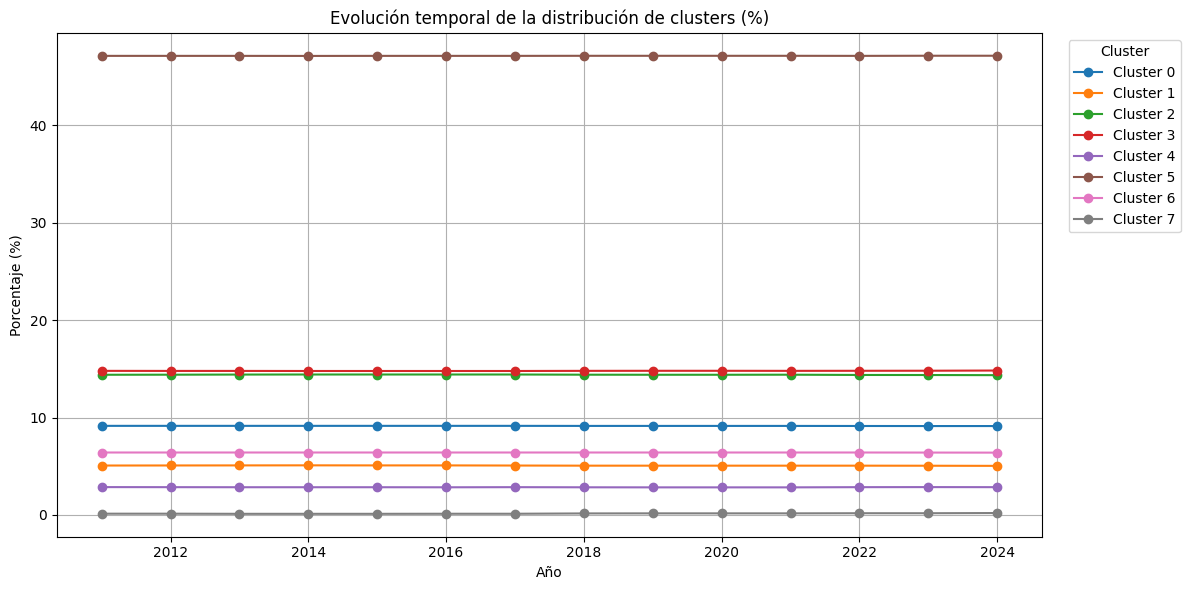

In [63]:
import matplotlib.pyplot as plt

# --- NADA de esto modifica df ---
tmp = df[["Ano", "Cluster_KMeans"]].copy()

tendencias = (
    tmp.groupby("Ano")["Cluster_KMeans"]
       .value_counts(normalize=True)     # proporción por año
       .mul(100)                         # a %
       .rename("Porcentaje")
       .reset_index()                    # columnas planas: Ano, Cluster_KMeans, Porcentaje
)

# Comprobación rápida
# display(tendencias.head())

# --- Gráfico de evolución temporal ---
plt.figure(figsize=(12,6))
for cluster in sorted(tendencias["Cluster_KMeans"].unique()):
    data_c = tendencias[tendencias["Cluster_KMeans"] == cluster]
    plt.plot(data_c["Ano"], data_c["Porcentaje"], marker="o", label=f"Cluster {cluster}")

plt.title("Evolución temporal de la distribución de clusters (%)")
plt.xlabel("Año")
plt.ylabel("Porcentaje (%)")
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()



